<a href="https://colab.research.google.com/github/ysj9909/GANs/blob/main/Least_Squares_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Least Squares Generative Adversarial Network**

  *  paper link : https://arxiv.org/pdf/1611.04076.pdf

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Hyper-parameters
batch_size = 100
latent_dim = 1024
num_classes = 10
learning_rate = 0.0007
num_epochs = 200

**데이터 준비 및 시각화**

In [7]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True, transform = data_transform)

dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True, num_workers = 4)

classes = ('plane', 'car', 'bird', 'cat', 
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


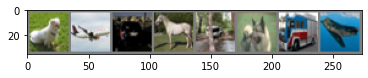

  dog plane   car horse truck   dog truck plane


In [8]:
# for showing images
def imshow(imgs):
  imgs = imgs / 2 + .5
  npimgs = imgs.numpy()
  plt.imshow(np.transpose(npimgs, (1, 2, 0)))
  plt.show()

dataiter = iter(dataloader)
imgs, labels = dataiter.next()

imshow(torchvision.utils.make_grid(imgs[:8]))
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


**모델 정의**

In [9]:
class Generator(nn.Module):
  def __init__(self, latent_dim = latent_dim, num_classes = 10):
    super(Generator, self).__init__()

    self.class_emb = nn.Embedding(num_classes, latent_dim)

    self.fc = nn.Linear(latent_dim, 8 * 8 * 256)

    self.upsampling_model = nn.Sequential(                                                                        
        nn.Upsample(scale_factor = 2),
        nn.Conv2d(256, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(128, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Upsample(scale_factor= 2),
        nn.Conv2d(64, 3, kernel_size = 3, stride = 1, padding = 1),
        nn.Tanh()
    )

  def forward(self, z, c):
    '''
    z : latent vector, shape of (batch_size, 1024 = (latent_dim))
    c : class labels, shape of (batch_size, )
    '''
    c_emb = self.class_emb(c)
    conditioned_z = torch.mul(z, c_emb)

    out = self.fc(conditioned_z)  # (batch_size, 8 * 8 * 256)
    out = out.view(-1, 256, 8, 8)

    imgs = self.upsampling_model(out)
    return imgs

In [10]:
class Discriminator(nn.Module):
  def __init__(self, num_classes = 10):
    super(Discriminator, self).__init__() 

    self.model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 5, stride = 2, padding = 2),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(0.25),
        nn.BatchNorm2d(256),
        nn.Conv2d(256, 512, kernel_size = 3, stride = 2, padding = 1),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Dropout(0.25),
        nn.BatchNorm2d(512),
    )

    self.fc = nn.Linear(2048, 1)
    
  def forward(self, imgs):
    # imgs : (batch_size, 3, 32, 32)
    out = self.model(imgs)   # (batch_size, 256, 4, 4)
    out = out.view(imgs.size(0), -1)
    out = self.fc(out)
    return out


In [11]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [12]:
# Loss and optimizer
criterion = nn.MSELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1 / 200], Generator Loss : 0.1751786321401596, Discriminator Loss : 0.1465713381767273
Epoch [2 / 200], Generator Loss : 0.2209286391735077, Discriminator Loss : 0.16963988542556763
Epoch [3 / 200], Generator Loss : 0.41105055809020996, Discriminator Loss : 0.1539090871810913
Epoch [4 / 200], Generator Loss : 0.17461830377578735, Discriminator Loss : 0.152242511510849
Epoch [5 / 200], Generator Loss : 0.20289413630962372, Discriminator Loss : 0.21909405291080475


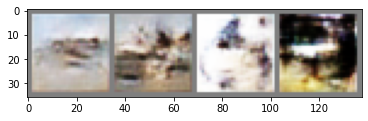

Epoch [6 / 200], Generator Loss : 0.2327762097120285, Discriminator Loss : 0.0991489589214325
Epoch [7 / 200], Generator Loss : 0.06203712150454521, Discriminator Loss : 0.3795831799507141
Epoch [8 / 200], Generator Loss : 0.23159217834472656, Discriminator Loss : 0.1440998613834381
Epoch [9 / 200], Generator Loss : 0.40097367763519287, Discriminator Loss : 0.21477439999580383
Epoch [10 / 200], Generator Loss : 0.42034852504730225, Discriminator Loss : 0.056512873619794846


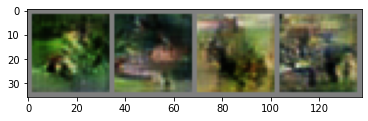

Epoch [11 / 200], Generator Loss : 0.2849471867084503, Discriminator Loss : 0.12569615244865417
Epoch [12 / 200], Generator Loss : 0.09569521993398666, Discriminator Loss : 0.14028644561767578
Epoch [13 / 200], Generator Loss : 0.6328617930412292, Discriminator Loss : 0.14536502957344055
Epoch [14 / 200], Generator Loss : 0.2346939593553543, Discriminator Loss : 0.0890534371137619
Epoch [15 / 200], Generator Loss : 0.5827586054801941, Discriminator Loss : 0.10452316701412201


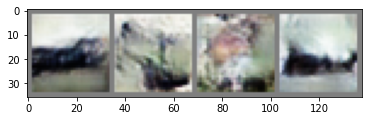

Epoch [16 / 200], Generator Loss : 0.07574726641178131, Discriminator Loss : 0.2080797702074051
Epoch [17 / 200], Generator Loss : 0.4780209958553314, Discriminator Loss : 0.038812682032585144
Epoch [18 / 200], Generator Loss : 0.42027077078819275, Discriminator Loss : 0.09711871296167374
Epoch [19 / 200], Generator Loss : 0.2199382185935974, Discriminator Loss : 0.06623372435569763
Epoch [20 / 200], Generator Loss : 0.3678440451622009, Discriminator Loss : 0.0410013385117054


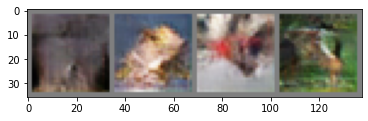

Epoch [21 / 200], Generator Loss : 0.18097063899040222, Discriminator Loss : 0.18213964998722076
Epoch [22 / 200], Generator Loss : 0.3924151062965393, Discriminator Loss : 0.034154895693063736
Epoch [23 / 200], Generator Loss : 0.4328274428844452, Discriminator Loss : 0.03442928194999695
Epoch [24 / 200], Generator Loss : 0.10324718058109283, Discriminator Loss : 0.17359432578086853
Epoch [25 / 200], Generator Loss : 0.453135222196579, Discriminator Loss : 0.03862756863236427


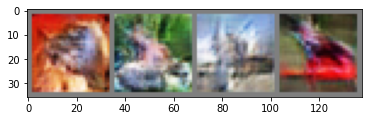

Epoch [26 / 200], Generator Loss : 0.4385177493095398, Discriminator Loss : 0.11744644492864609
Epoch [27 / 200], Generator Loss : 0.6344097852706909, Discriminator Loss : 0.06458105891942978
Epoch [28 / 200], Generator Loss : 0.33444446325302124, Discriminator Loss : 0.034813292324543
Epoch [29 / 200], Generator Loss : 0.4274013340473175, Discriminator Loss : 0.03564467653632164
Epoch [30 / 200], Generator Loss : 0.19008666276931763, Discriminator Loss : 0.13151955604553223


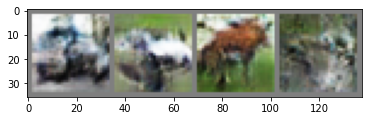

Epoch [31 / 200], Generator Loss : 0.23116515576839447, Discriminator Loss : 0.11060947179794312
Epoch [32 / 200], Generator Loss : 0.12260403484106064, Discriminator Loss : 0.12686584889888763
Epoch [33 / 200], Generator Loss : 0.6320922374725342, Discriminator Loss : 0.06496554613113403
Epoch [34 / 200], Generator Loss : 0.20416320860385895, Discriminator Loss : 0.10009542107582092
Epoch [35 / 200], Generator Loss : 0.1847371608018875, Discriminator Loss : 0.04260753467679024


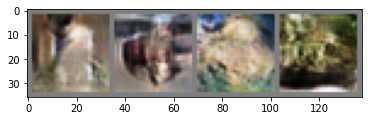

Epoch [36 / 200], Generator Loss : 0.4842548370361328, Discriminator Loss : 0.08260196447372437
Epoch [37 / 200], Generator Loss : 0.27847132086753845, Discriminator Loss : 0.03758032247424126
Epoch [38 / 200], Generator Loss : 0.24330256879329681, Discriminator Loss : 0.0800328254699707
Epoch [39 / 200], Generator Loss : 0.6256235837936401, Discriminator Loss : 0.12281595915555954
Epoch [40 / 200], Generator Loss : 0.5137849450111389, Discriminator Loss : 0.07989988476037979


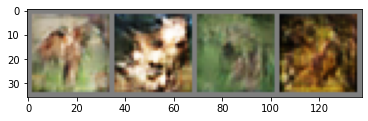

Epoch [41 / 200], Generator Loss : 0.28661254048347473, Discriminator Loss : 0.08811624348163605
Epoch [42 / 200], Generator Loss : 0.49761736392974854, Discriminator Loss : 0.1156475767493248
Epoch [43 / 200], Generator Loss : 0.13306836783885956, Discriminator Loss : 0.15919658541679382
Epoch [44 / 200], Generator Loss : 0.48166555166244507, Discriminator Loss : 0.047085389494895935
Epoch [45 / 200], Generator Loss : 0.2966722548007965, Discriminator Loss : 0.039046987891197205


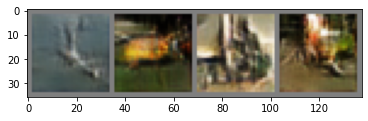

Epoch [46 / 200], Generator Loss : 0.4803738296031952, Discriminator Loss : 0.07453996688127518
Epoch [47 / 200], Generator Loss : 0.692338228225708, Discriminator Loss : 0.09274757653474808
Epoch [48 / 200], Generator Loss : 0.36337459087371826, Discriminator Loss : 0.03356296569108963
Epoch [49 / 200], Generator Loss : 0.7989965081214905, Discriminator Loss : 0.05536587908864021
Epoch [50 / 200], Generator Loss : 0.5756238698959351, Discriminator Loss : 0.08026528358459473


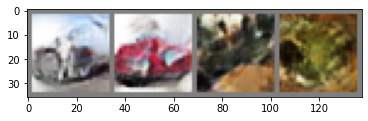

Epoch [51 / 200], Generator Loss : 0.44901904463768005, Discriminator Loss : 0.11364249885082245
Epoch [52 / 200], Generator Loss : 0.16324752569198608, Discriminator Loss : 0.11612206697463989
Epoch [53 / 200], Generator Loss : 0.45798978209495544, Discriminator Loss : 0.0662280023097992
Epoch [54 / 200], Generator Loss : 0.6632278561592102, Discriminator Loss : 0.19308361411094666
Epoch [55 / 200], Generator Loss : 0.2665594220161438, Discriminator Loss : 0.02450268343091011


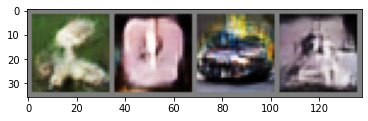

Epoch [56 / 200], Generator Loss : 0.267117977142334, Discriminator Loss : 0.06457068771123886
Epoch [57 / 200], Generator Loss : 0.40421420335769653, Discriminator Loss : 0.024616576731204987
Epoch [58 / 200], Generator Loss : 0.32662948966026306, Discriminator Loss : 0.02886050194501877
Epoch [59 / 200], Generator Loss : 0.49979308247566223, Discriminator Loss : 0.15962308645248413
Epoch [60 / 200], Generator Loss : 0.26386067271232605, Discriminator Loss : 0.07213761657476425


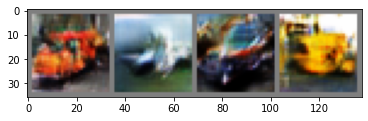

Epoch [61 / 200], Generator Loss : 0.21386884152889252, Discriminator Loss : 0.10331547260284424
Epoch [62 / 200], Generator Loss : 0.24638564884662628, Discriminator Loss : 0.08420945703983307
Epoch [63 / 200], Generator Loss : 0.5385807156562805, Discriminator Loss : 0.08449970185756683
Epoch [64 / 200], Generator Loss : 0.3426148295402527, Discriminator Loss : 0.06676313281059265
Epoch [65 / 200], Generator Loss : 0.18869829177856445, Discriminator Loss : 0.07528712600469589


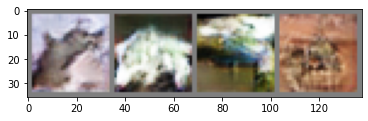

Epoch [66 / 200], Generator Loss : 0.3403242528438568, Discriminator Loss : 0.03137567639350891
Epoch [67 / 200], Generator Loss : 0.2208445519208908, Discriminator Loss : 0.09728432446718216
Epoch [68 / 200], Generator Loss : 0.47114285826683044, Discriminator Loss : 0.09552031755447388
Epoch [69 / 200], Generator Loss : 0.3730394244194031, Discriminator Loss : 0.08289840817451477
Epoch [70 / 200], Generator Loss : 0.34404677152633667, Discriminator Loss : 0.01738462783396244


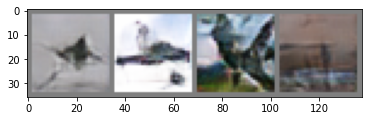

Epoch [71 / 200], Generator Loss : 0.3459405303001404, Discriminator Loss : 0.06186907738447189
Epoch [72 / 200], Generator Loss : 0.659850001335144, Discriminator Loss : 0.06251773983240128
Epoch [73 / 200], Generator Loss : 0.1556907743215561, Discriminator Loss : 0.17085406184196472
Epoch [74 / 200], Generator Loss : 0.5577171444892883, Discriminator Loss : 0.10774139314889908
Epoch [75 / 200], Generator Loss : 0.17596949636936188, Discriminator Loss : 0.2157103568315506


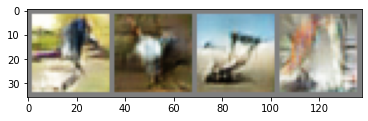

Epoch [76 / 200], Generator Loss : 0.15493255853652954, Discriminator Loss : 0.093812495470047
Epoch [77 / 200], Generator Loss : 0.563331127166748, Discriminator Loss : 0.06884126365184784
Epoch [78 / 200], Generator Loss : 0.552314043045044, Discriminator Loss : 0.21799562871456146
Epoch [79 / 200], Generator Loss : 0.292203426361084, Discriminator Loss : 0.1286461502313614
Epoch [80 / 200], Generator Loss : 0.6499562859535217, Discriminator Loss : 0.1593892127275467


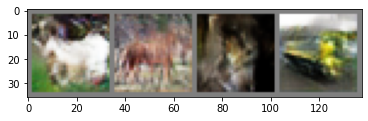

Epoch [81 / 200], Generator Loss : 0.8014489412307739, Discriminator Loss : 0.0851517990231514
Epoch [82 / 200], Generator Loss : 0.2346561700105667, Discriminator Loss : 0.07179497182369232
Epoch [83 / 200], Generator Loss : 0.23760731518268585, Discriminator Loss : 0.13759320974349976
Epoch [84 / 200], Generator Loss : 0.3482358455657959, Discriminator Loss : 0.0690307766199112
Epoch [85 / 200], Generator Loss : 0.22376982867717743, Discriminator Loss : 0.12221302837133408


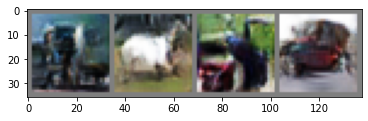

Epoch [86 / 200], Generator Loss : 0.2960115075111389, Discriminator Loss : 0.07291397452354431
Epoch [87 / 200], Generator Loss : 0.3929694592952728, Discriminator Loss : 0.03452517092227936
Epoch [88 / 200], Generator Loss : 0.3233199715614319, Discriminator Loss : 0.13595139980316162
Epoch [89 / 200], Generator Loss : 1.08834969997406, Discriminator Loss : 0.24274708330631256
Epoch [90 / 200], Generator Loss : 0.16041406989097595, Discriminator Loss : 0.11523182690143585


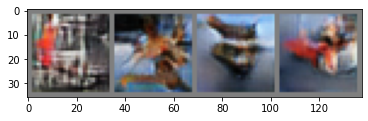

Epoch [91 / 200], Generator Loss : 0.4460553526878357, Discriminator Loss : 0.036291737109422684
Epoch [92 / 200], Generator Loss : 0.41839492321014404, Discriminator Loss : 0.05843648314476013
Epoch [93 / 200], Generator Loss : 0.42922553420066833, Discriminator Loss : 0.08299774676561356
Epoch [94 / 200], Generator Loss : 0.44523677229881287, Discriminator Loss : 0.03302379325032234
Epoch [95 / 200], Generator Loss : 0.3230060040950775, Discriminator Loss : 0.050674211233854294


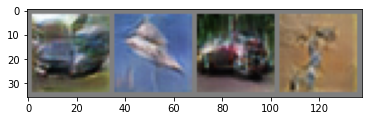

Epoch [96 / 200], Generator Loss : 0.22337336838245392, Discriminator Loss : 0.0546373575925827
Epoch [97 / 200], Generator Loss : 0.4852535128593445, Discriminator Loss : 0.055731963366270065
Epoch [98 / 200], Generator Loss : 0.22861965000629425, Discriminator Loss : 0.13856026530265808
Epoch [99 / 200], Generator Loss : 0.3690834641456604, Discriminator Loss : 0.1630653738975525
Epoch [100 / 200], Generator Loss : 0.39635390043258667, Discriminator Loss : 0.11327370256185532


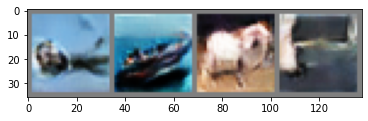

Epoch [101 / 200], Generator Loss : 0.4734121561050415, Discriminator Loss : 0.05870206654071808
Epoch [102 / 200], Generator Loss : 0.6633951663970947, Discriminator Loss : 0.04554789140820503
Epoch [103 / 200], Generator Loss : 0.48961547017097473, Discriminator Loss : 0.022978266701102257
Epoch [104 / 200], Generator Loss : 0.6043537259101868, Discriminator Loss : 0.23858147859573364
Epoch [105 / 200], Generator Loss : 0.2869388461112976, Discriminator Loss : 0.044094450771808624


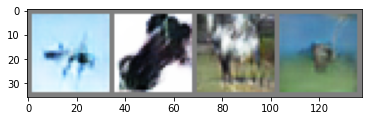

Epoch [106 / 200], Generator Loss : 0.3249414265155792, Discriminator Loss : 0.08124811202287674
Epoch [107 / 200], Generator Loss : 0.6200681328773499, Discriminator Loss : 0.0483013316988945
Epoch [108 / 200], Generator Loss : 0.552789568901062, Discriminator Loss : 0.1348208636045456
Epoch [109 / 200], Generator Loss : 0.3042159676551819, Discriminator Loss : 0.18900685012340546
Epoch [110 / 200], Generator Loss : 0.29982268810272217, Discriminator Loss : 0.04415611922740936


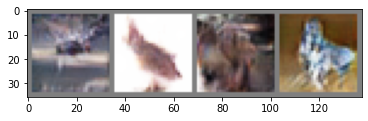

Epoch [111 / 200], Generator Loss : 0.3829829692840576, Discriminator Loss : 0.07176301628351212
Epoch [112 / 200], Generator Loss : 0.3493286073207855, Discriminator Loss : 0.03263813257217407
Epoch [113 / 200], Generator Loss : 0.6150882840156555, Discriminator Loss : 0.026323698461055756
Epoch [114 / 200], Generator Loss : 0.2889435291290283, Discriminator Loss : 0.026484042406082153
Epoch [115 / 200], Generator Loss : 0.4910729229450226, Discriminator Loss : 0.14425572752952576


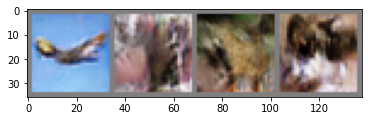

Epoch [116 / 200], Generator Loss : 0.3974721431732178, Discriminator Loss : 0.06723546236753464
Epoch [117 / 200], Generator Loss : 0.2541148364543915, Discriminator Loss : 0.11264971643686295
Epoch [118 / 200], Generator Loss : 0.32299506664276123, Discriminator Loss : 0.041732899844646454
Epoch [119 / 200], Generator Loss : 0.4250575304031372, Discriminator Loss : 0.055120278149843216
Epoch [120 / 200], Generator Loss : 0.45944350957870483, Discriminator Loss : 0.07993808388710022


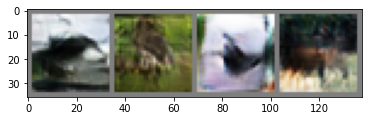

Epoch [121 / 200], Generator Loss : 0.5410202741622925, Discriminator Loss : 0.05848460644483566
Epoch [122 / 200], Generator Loss : 0.46954455971717834, Discriminator Loss : 0.035741835832595825
Epoch [123 / 200], Generator Loss : 0.25820475816726685, Discriminator Loss : 0.12669959664344788
Epoch [124 / 200], Generator Loss : 0.3570164740085602, Discriminator Loss : 0.0391952209174633
Epoch [125 / 200], Generator Loss : 0.20983566343784332, Discriminator Loss : 0.18218876421451569


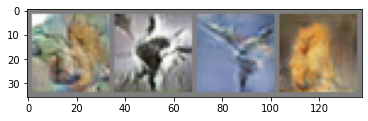

Epoch [126 / 200], Generator Loss : 0.47716251015663147, Discriminator Loss : 0.07586020231246948
Epoch [127 / 200], Generator Loss : 0.2148400843143463, Discriminator Loss : 0.16281896829605103
Epoch [128 / 200], Generator Loss : 0.28438425064086914, Discriminator Loss : 0.1159878745675087
Epoch [129 / 200], Generator Loss : 0.16528108716011047, Discriminator Loss : 0.2788335382938385
Epoch [130 / 200], Generator Loss : 0.2903560996055603, Discriminator Loss : 0.058635786175727844


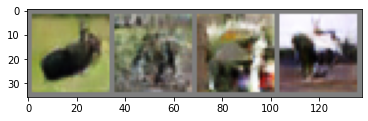

Epoch [131 / 200], Generator Loss : 0.09957139939069748, Discriminator Loss : 0.11014386266469955
Epoch [132 / 200], Generator Loss : 0.6388939619064331, Discriminator Loss : 0.1373274326324463
Epoch [133 / 200], Generator Loss : 0.4126485586166382, Discriminator Loss : 0.1297721415758133
Epoch [134 / 200], Generator Loss : 0.23453521728515625, Discriminator Loss : 0.03370053693652153
Epoch [135 / 200], Generator Loss : 0.4845563769340515, Discriminator Loss : 0.20325616002082825


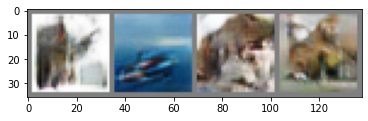

Epoch [136 / 200], Generator Loss : 0.6207649111747742, Discriminator Loss : 0.02870868146419525
Epoch [137 / 200], Generator Loss : 0.5328989028930664, Discriminator Loss : 0.046158261597156525
Epoch [138 / 200], Generator Loss : 0.38965171575546265, Discriminator Loss : 0.09667322039604187
Epoch [139 / 200], Generator Loss : 0.2282731980085373, Discriminator Loss : 0.08145061135292053
Epoch [140 / 200], Generator Loss : 0.3799121081829071, Discriminator Loss : 0.0362187884747982


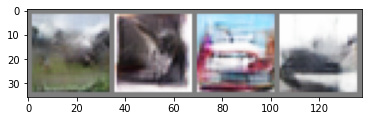

Epoch [141 / 200], Generator Loss : 0.3351747393608093, Discriminator Loss : 0.032680559903383255
Epoch [142 / 200], Generator Loss : 0.5633503794670105, Discriminator Loss : 0.07659739255905151
Epoch [143 / 200], Generator Loss : 0.2543882131576538, Discriminator Loss : 0.10812031477689743
Epoch [144 / 200], Generator Loss : 0.17623119056224823, Discriminator Loss : 0.057451337575912476
Epoch [145 / 200], Generator Loss : 0.08109311759471893, Discriminator Loss : 0.22815971076488495


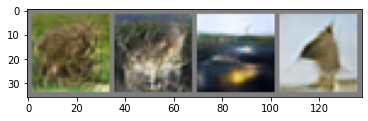

Epoch [146 / 200], Generator Loss : 0.770558774471283, Discriminator Loss : 0.1851913332939148
Epoch [147 / 200], Generator Loss : 0.1711408644914627, Discriminator Loss : 0.12481223046779633
Epoch [148 / 200], Generator Loss : 0.2711954414844513, Discriminator Loss : 0.03080211952328682
Epoch [149 / 200], Generator Loss : 0.5953165888786316, Discriminator Loss : 0.08950276672840118
Epoch [150 / 200], Generator Loss : 0.03976304829120636, Discriminator Loss : 0.16631650924682617


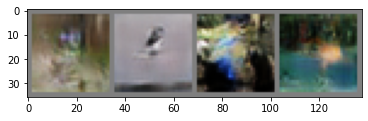

Epoch [151 / 200], Generator Loss : 0.14278796315193176, Discriminator Loss : 0.05073630064725876
Epoch [152 / 200], Generator Loss : 0.40317946672439575, Discriminator Loss : 0.04140361025929451
Epoch [153 / 200], Generator Loss : 0.2325202077627182, Discriminator Loss : 0.06517313420772552
Epoch [154 / 200], Generator Loss : 0.26922905445098877, Discriminator Loss : 0.09811398386955261
Epoch [155 / 200], Generator Loss : 0.37346351146698, Discriminator Loss : 0.17254576086997986


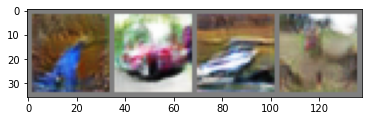

Epoch [156 / 200], Generator Loss : 0.5158738493919373, Discriminator Loss : 0.03491761162877083
Epoch [157 / 200], Generator Loss : 0.5749117732048035, Discriminator Loss : 0.03699939697980881
Epoch [158 / 200], Generator Loss : 0.39238616824150085, Discriminator Loss : 0.12757964432239532
Epoch [159 / 200], Generator Loss : 0.2808679938316345, Discriminator Loss : 0.05256732925772667
Epoch [160 / 200], Generator Loss : 0.3551693558692932, Discriminator Loss : 0.09641767293214798


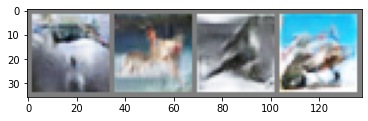

Epoch [161 / 200], Generator Loss : 0.4047638177871704, Discriminator Loss : 0.07009517401456833
Epoch [162 / 200], Generator Loss : 0.3793259263038635, Discriminator Loss : 0.07609759271144867
Epoch [163 / 200], Generator Loss : 0.23606008291244507, Discriminator Loss : 0.1635531336069107
Epoch [164 / 200], Generator Loss : 0.3272453248500824, Discriminator Loss : 0.10434932261705399
Epoch [165 / 200], Generator Loss : 0.32065349817276, Discriminator Loss : 0.04964463412761688


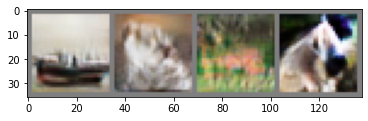

Epoch [166 / 200], Generator Loss : 0.3334995210170746, Discriminator Loss : 0.021153099834918976
Epoch [167 / 200], Generator Loss : 0.3393405079841614, Discriminator Loss : 0.1609380543231964
Epoch [168 / 200], Generator Loss : 0.4196719229221344, Discriminator Loss : 0.1491515040397644
Epoch [169 / 200], Generator Loss : 0.1451241672039032, Discriminator Loss : 0.06478756666183472
Epoch [170 / 200], Generator Loss : 0.32363685965538025, Discriminator Loss : 0.06429491192102432


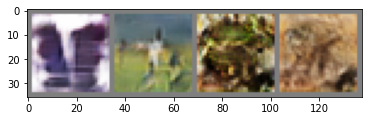

Epoch [171 / 200], Generator Loss : 0.46170201897621155, Discriminator Loss : 0.09044083207845688
Epoch [172 / 200], Generator Loss : 0.5932169556617737, Discriminator Loss : 0.14248867332935333
Epoch [173 / 200], Generator Loss : 0.4345220923423767, Discriminator Loss : 0.03318175673484802
Epoch [174 / 200], Generator Loss : 0.36040258407592773, Discriminator Loss : 0.12372922897338867
Epoch [175 / 200], Generator Loss : 0.30217912793159485, Discriminator Loss : 0.13327787816524506


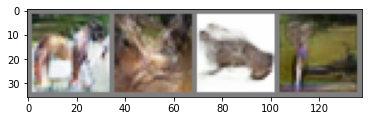

Epoch [176 / 200], Generator Loss : 0.2746683955192566, Discriminator Loss : 0.08897587656974792
Epoch [177 / 200], Generator Loss : 0.3223460018634796, Discriminator Loss : 0.03684605285525322
Epoch [178 / 200], Generator Loss : 0.18485072255134583, Discriminator Loss : 0.12882813811302185
Epoch [179 / 200], Generator Loss : 0.21076945960521698, Discriminator Loss : 0.07918211817741394
Epoch [180 / 200], Generator Loss : 0.25589224696159363, Discriminator Loss : 0.06761931627988815


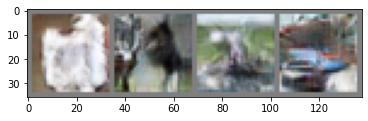

Epoch [181 / 200], Generator Loss : 0.49542510509490967, Discriminator Loss : 0.16017891466617584
Epoch [182 / 200], Generator Loss : 0.27942919731140137, Discriminator Loss : 0.038313452154397964
Epoch [183 / 200], Generator Loss : 0.18014198541641235, Discriminator Loss : 0.13534307479858398
Epoch [184 / 200], Generator Loss : 0.37724569439888, Discriminator Loss : 0.015256976708769798
Epoch [185 / 200], Generator Loss : 0.5463900566101074, Discriminator Loss : 0.02502232789993286


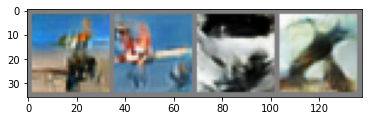

Epoch [186 / 200], Generator Loss : 0.6219298243522644, Discriminator Loss : 0.1083986684679985
Epoch [187 / 200], Generator Loss : 0.5620572566986084, Discriminator Loss : 0.08805423229932785
Epoch [188 / 200], Generator Loss : 0.25934913754463196, Discriminator Loss : 0.055362991988658905
Epoch [189 / 200], Generator Loss : 0.31290677189826965, Discriminator Loss : 0.11466620862483978
Epoch [190 / 200], Generator Loss : 0.22362838685512543, Discriminator Loss : 0.05632597953081131


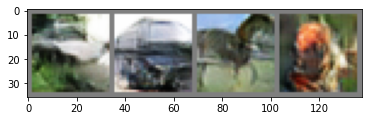

Epoch [191 / 200], Generator Loss : 0.20105651021003723, Discriminator Loss : 0.11087384074926376
Epoch [192 / 200], Generator Loss : 0.6052162647247314, Discriminator Loss : 0.31479963660240173
Epoch [193 / 200], Generator Loss : 0.44756120443344116, Discriminator Loss : 0.15111926198005676
Epoch [194 / 200], Generator Loss : 0.368448942899704, Discriminator Loss : 0.02658369392156601
Epoch [195 / 200], Generator Loss : 0.3430296778678894, Discriminator Loss : 0.07821314036846161


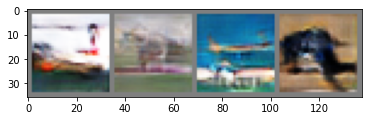

Epoch [196 / 200], Generator Loss : 0.5426825284957886, Discriminator Loss : 0.05584811419248581
Epoch [197 / 200], Generator Loss : 0.30272018909454346, Discriminator Loss : 0.03759035840630531
Epoch [198 / 200], Generator Loss : 0.38344764709472656, Discriminator Loss : 0.04541690647602081
Epoch [199 / 200], Generator Loss : 0.22090591490268707, Discriminator Loss : 0.08688722550868988
Epoch [200 / 200], Generator Loss : 0.23628875613212585, Discriminator Loss : 0.05577017366886139


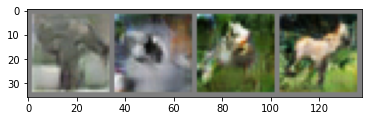

In [14]:
# 모델을 훈련시킵니다
for epoch in range(num_epochs):
  for imgs, labels in dataloader:
    real_imgs, labels = imgs.to(device), labels.to(device)

    z = torch.normal(mean = 0, std = 1, size = (imgs.size(0), latent_dim)).to(device)
    fake_imgs = generator(z, labels)

    # Ground truth for loss fucntions
    real = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad = False)
    fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad = False)

    #----------------
    # Traning G
    #----------------
    optimizer_G.zero_grad()

    loss_G = criterion(discriminator(fake_imgs), real) / 2
    loss_G.backward()

    optimizer_G.step()

    #----------------
    # Traning D
    #----------------
    optimizer_D.zero_grad()

    loss_D = (criterion(discriminator(real_imgs), real) + criterion(discriminator(fake_imgs.detach()), fake)) / 2
    loss_D.backward()

    optimizer_D.step()

  print(f"Epoch [{epoch + 1} / {num_epochs}], Generator Loss : {loss_G.item()}, Discriminator Loss : {loss_D.item()}")
  if (epoch + 1) % 5 == 0:
    imshow(torchvision.utils.make_grid(fake_imgs[:4].detach().cpu()))

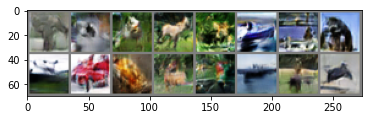

In [15]:
imshow(torchvision.utils.make_grid(fake_imgs[:16].detach().cpu()))